In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import os
import sys
sys.path.append('.')

from lib.prepare_data import make_cut, to_categorical
from lib.train import iterate_params, choose_params, nb_possibility
from lib.show import compare_repartition, histo_continuous, show_hyperparam_opti
from lib.all import all_in_one

In [2]:
os.environ['PYSPARK_DRIVER_PYTHON_OPTS']= "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

spark = SparkSession \
    .builder \
    .appName("renovation") \
    .getOrCreate()

# set this parameter for date issue before 1582 (dpe database)
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [3]:
# import files 
# File location and type
file_location_array = [
    {"location" : "./training/pred_tremi.csv", "name": "pred_tremi_full", "delimiter": ","},
    {"location" : "./training/dico.csv", "name": "dictionary", "delimiter": "\t"}
]
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
dataframes = {}

# The applied options are for CSV files. For other file types, these will be ignored.
for file in file_location_array:
    delimiter = file["delimiter"]
    file_location = file["location"]
    name = file["name"]
    dataframes[file["name"]] = (
        spark.read.format(file_type) \
        .option("inferSchema", infer_schema)
        .option("header", first_row_is_header)
        .option("sep", delimiter)
        .load(file_location)
    )

In [4]:
# name the important datasets and cast to type
training_tremi = (
    dataframes['pred_tremi_full'].withColumns({
        'surface' : F.col('surface').cast('float'),
        'heating_production' : F.col('heating_production').cast('int'),
        'heating_emission' : F.col('heating_emission').cast('int')
    })
)

dictionary = dataframes['dictionary']

In [5]:
# split training and prediction datasets
training_surf = training_tremi.filter(F.col('surface').isNotNull()).drop('heating_emission', 'heating_production')
predicting_surf = training_tremi.filter(F.col('surface').isNull()).drop('heating_emission', 'heating_production')

training_prod = training_tremi.filter(F.col('heating_production').isNotNull()).drop('heating_emission', 'surface')
predicting_prod = training_tremi.filter(F.col('heating_production').isNull()).drop('heating_emission', 'surface')

training_em = training_tremi.filter(F.col('heating_emission').isNotNull()).drop('surface', 'heating_production')
predicting_em = training_tremi.filter(F.col('heating_emission').isNull()).drop('surface', 'heating_production')

print(f"""
{training_surf.count() =}
{predicting_surf.count() =}\n
{training_prod.count() =}
{predicting_prod.count() =}\n
{training_em.count() =}
{predicting_em.count() =}
""")


training_surf.count() =12565
predicting_surf.count() =26933

training_prod.count() =11128
predicting_prod.count() =28370

training_em.count() =12558
predicting_em.count() =26940



# input variables

c:\Users\arocheteau\OneDrive - ASI\Documents\1_perso\projet\datalake\notebook\pySpark\lib\show.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%1.2f%%' %i for i in vals])


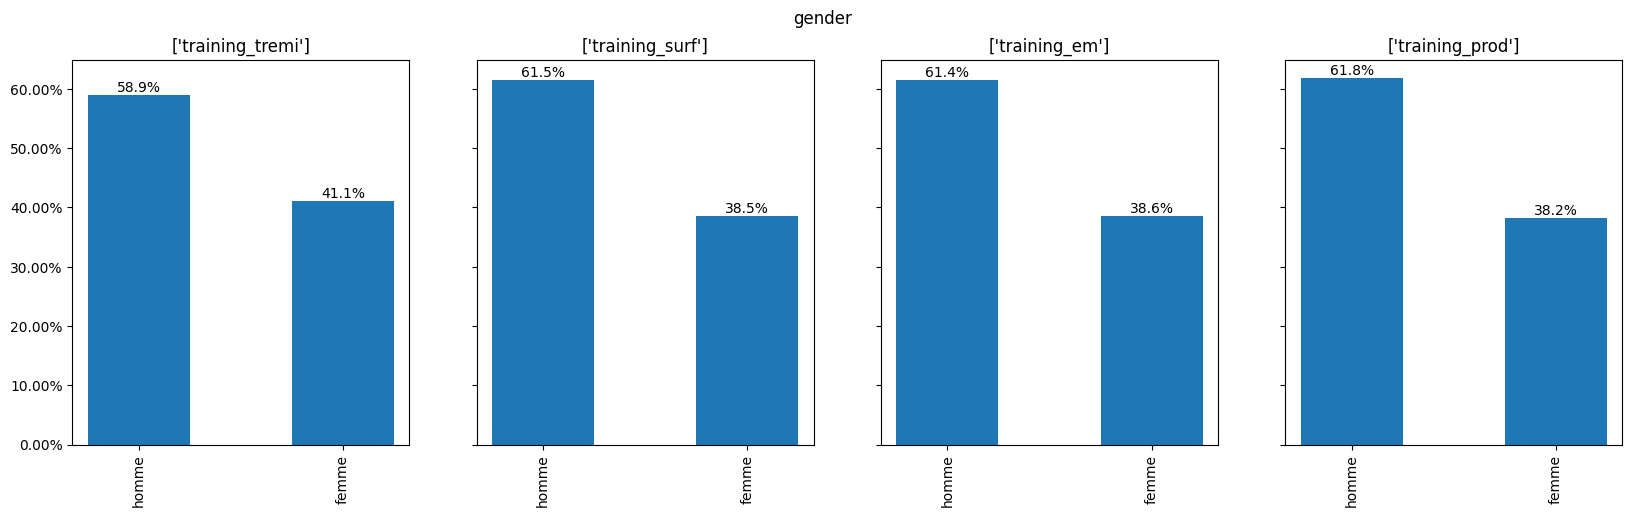

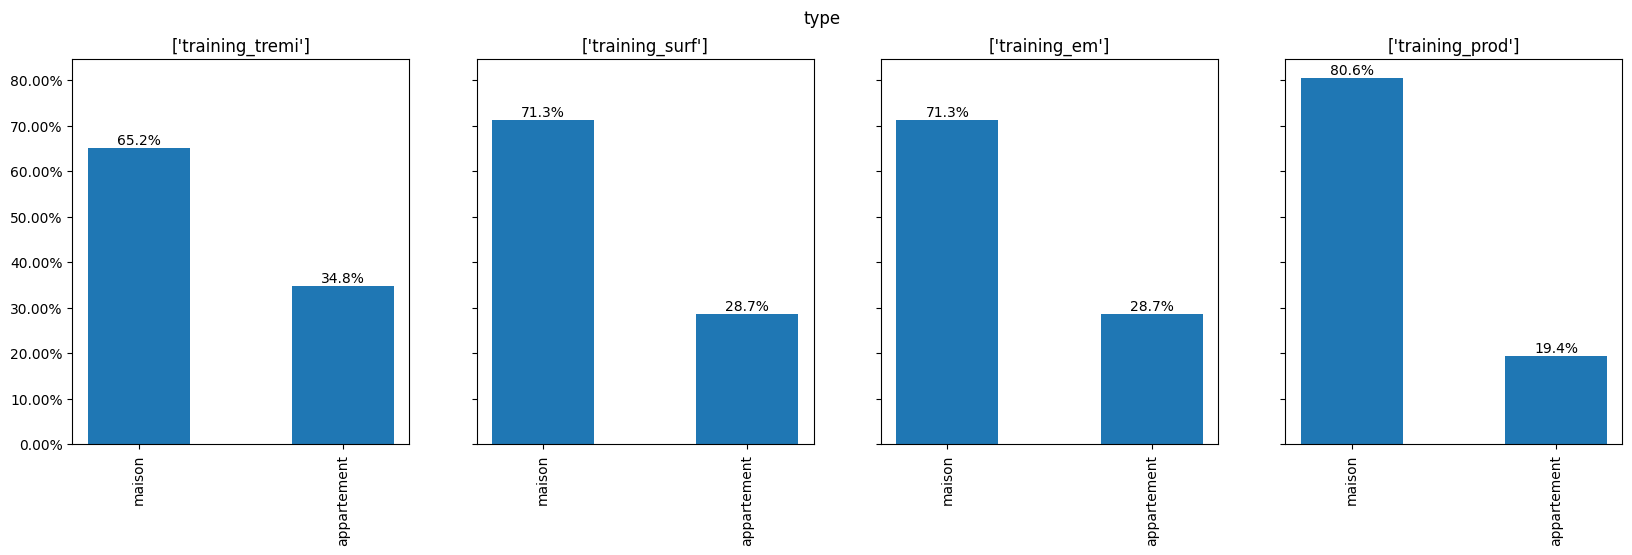

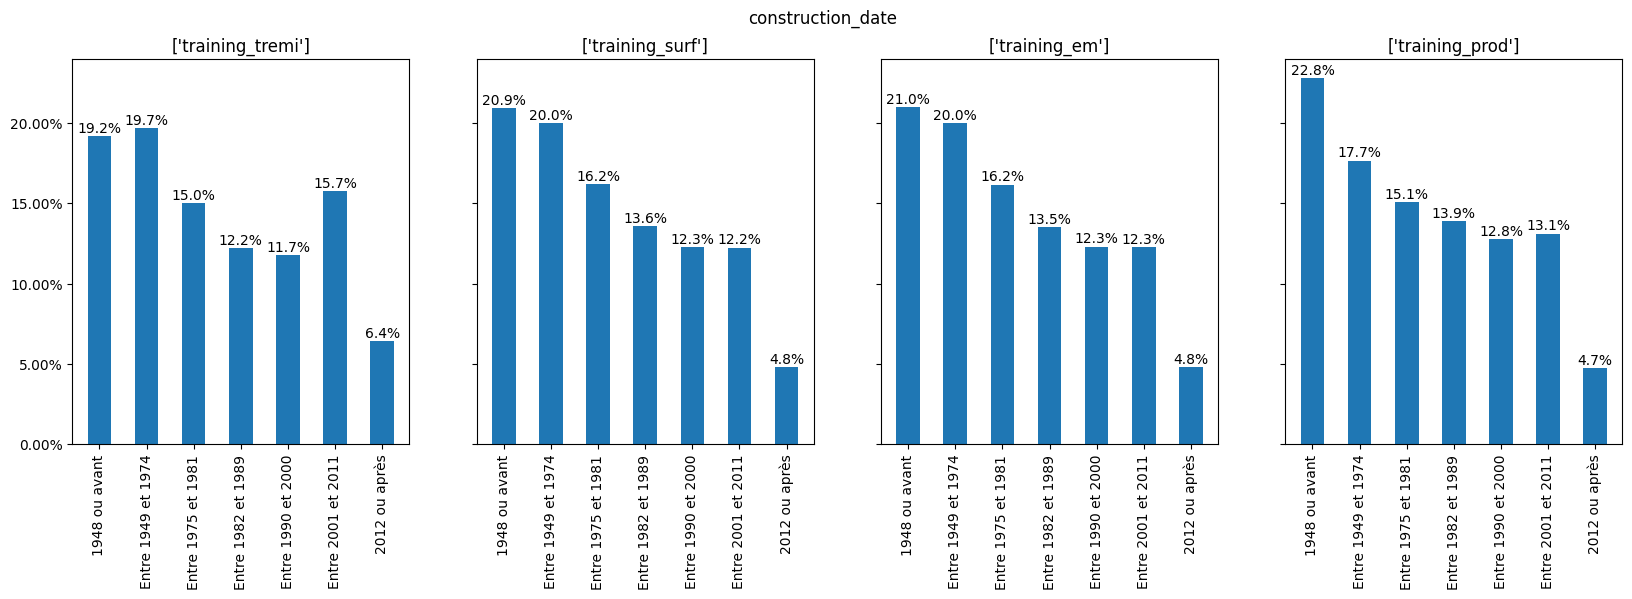

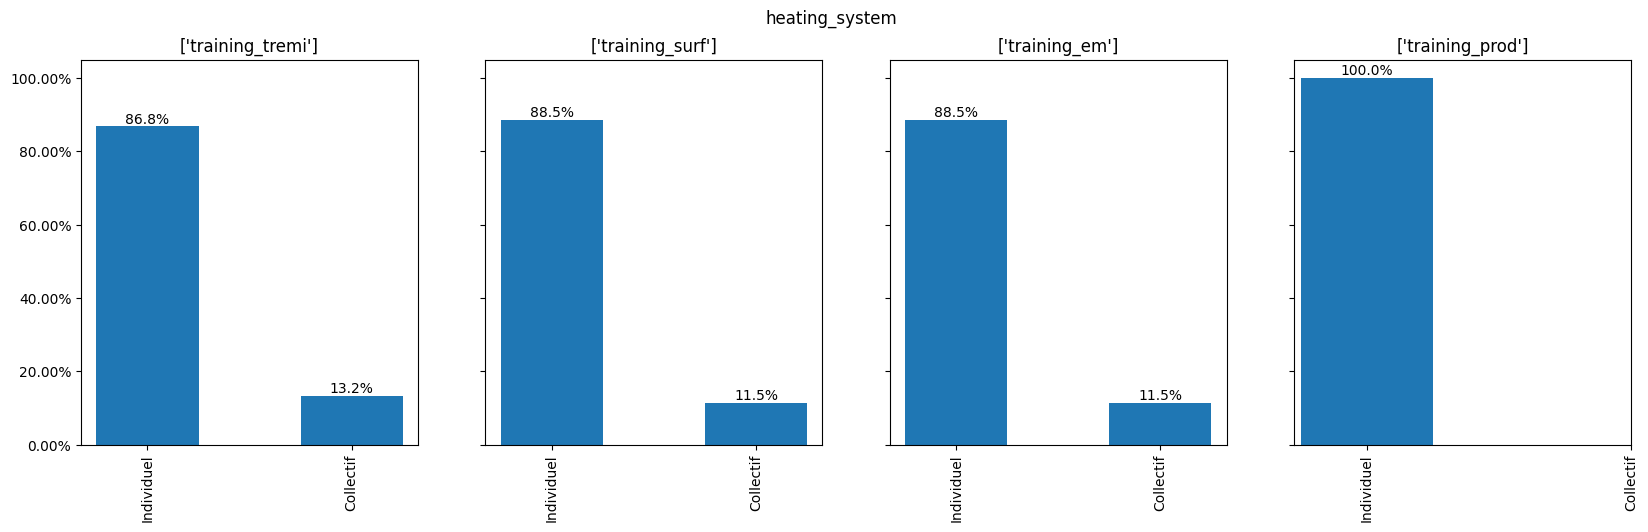

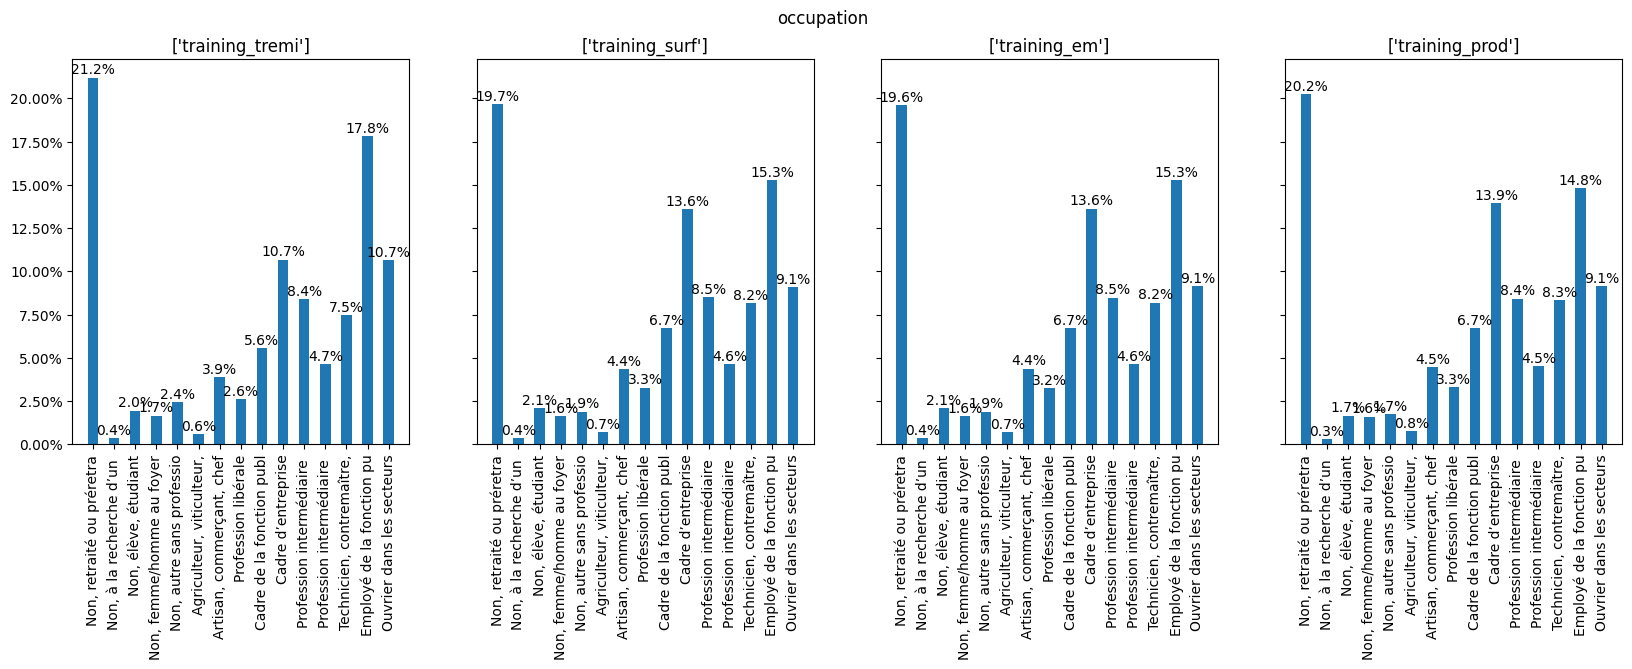

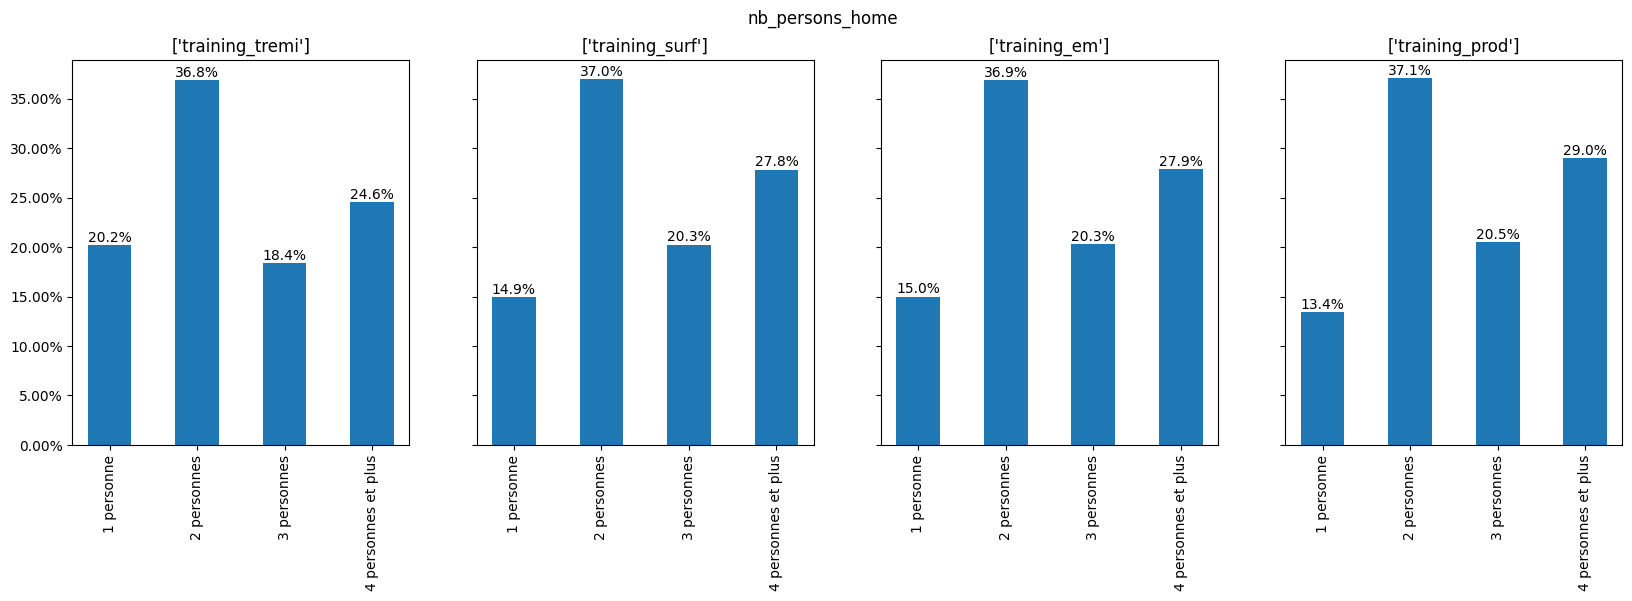

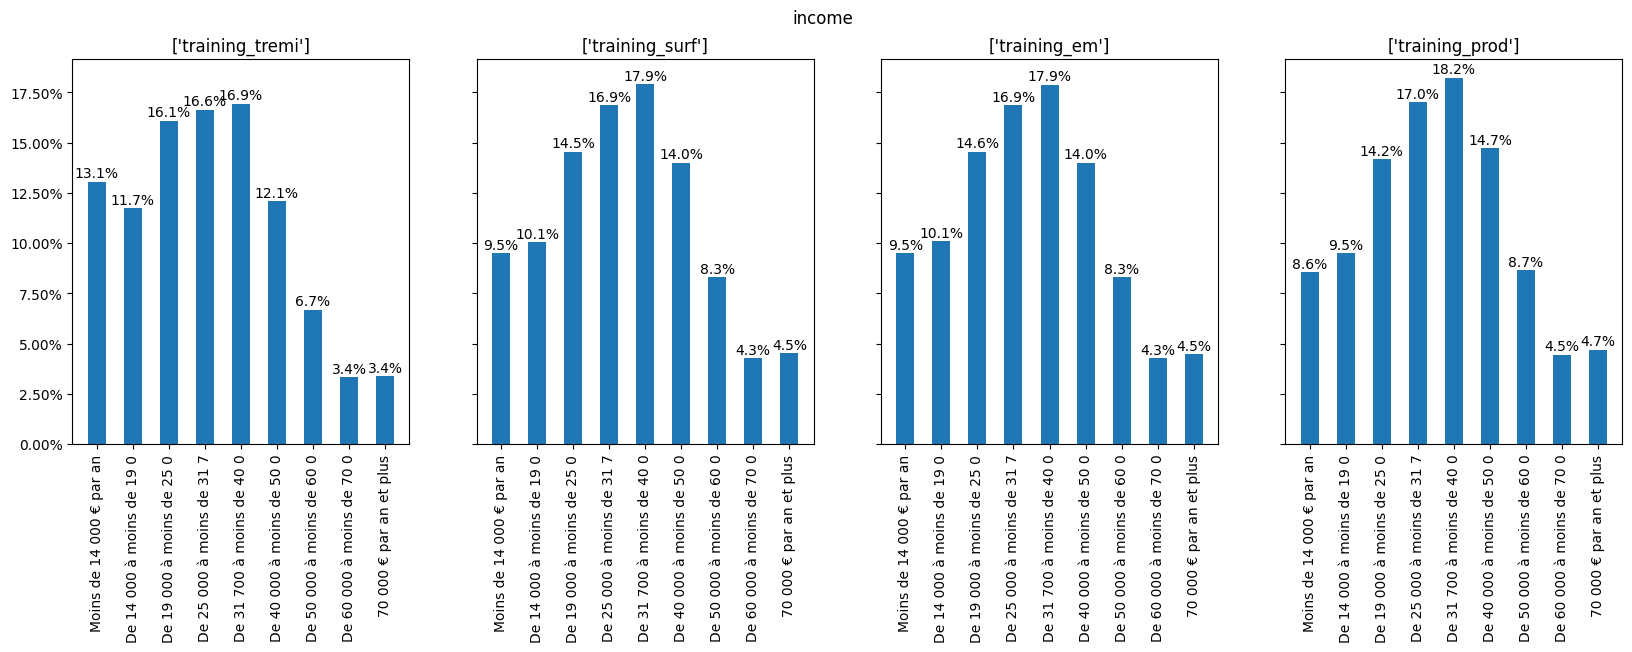

In [6]:
dfs = [training_tremi, training_surf, training_em, training_prod]
compare_repartition(dfs, dictionary, 'gender')
compare_repartition(dfs, dictionary, 'type')
compare_repartition(dfs, dictionary, 'construction_date')
compare_repartition(dfs, dictionary, 'heating_system')
compare_repartition(dfs, dictionary, 'occupation')
compare_repartition(dfs, dictionary, 'nb_persons_home')
compare_repartition(dfs, dictionary, 'income')

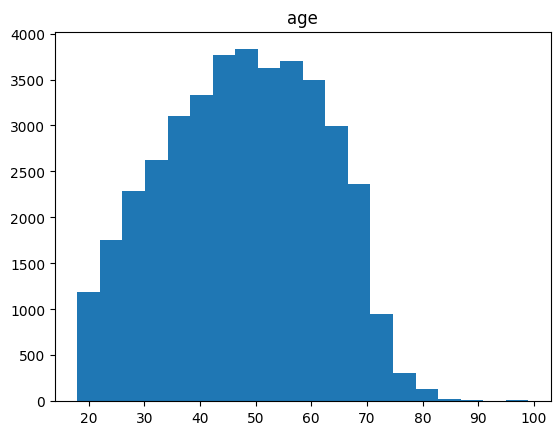

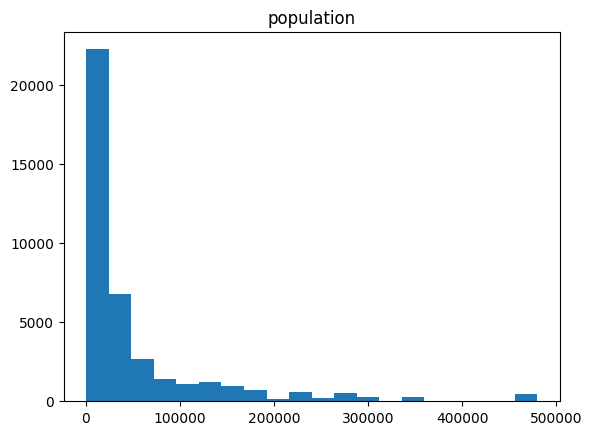

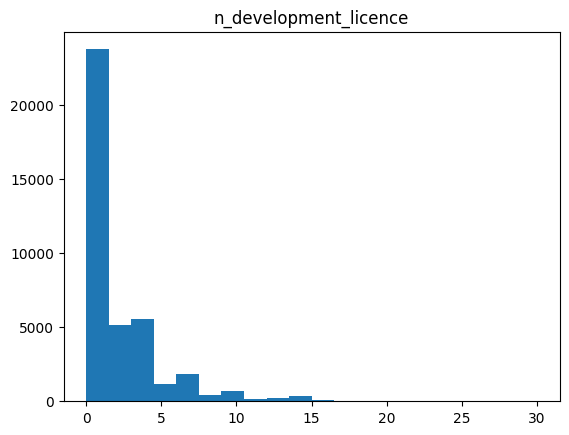

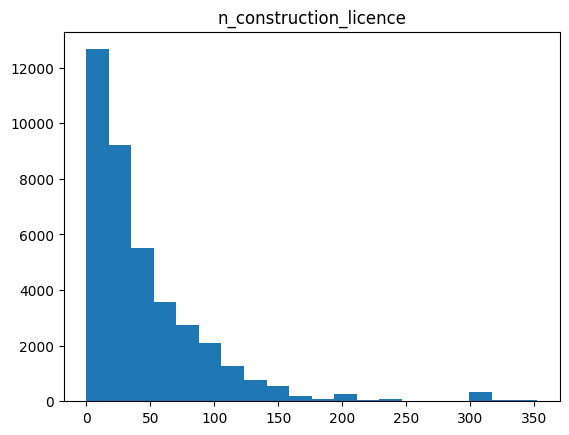

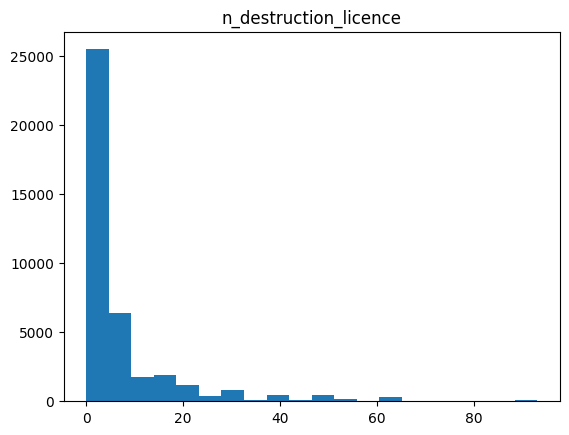

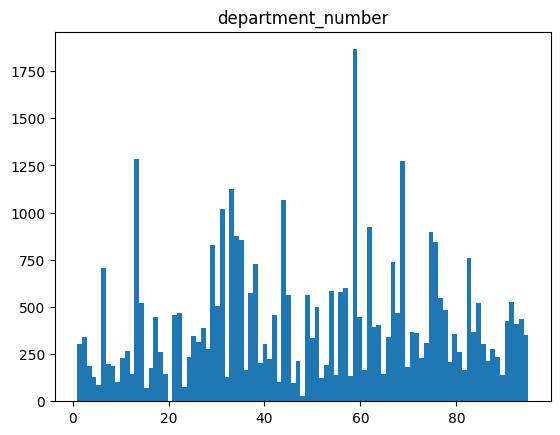

In [7]:
histo_continuous(training_tremi, 'age')
histo_continuous(training_tremi, 'population')
histo_continuous(training_tremi, 'n_development_licence')
histo_continuous(training_tremi, 'n_construction_licence')
histo_continuous(training_tremi, 'n_destruction_licence')
histo_continuous(training_tremi, 'department_number', 95)

# ouput variables

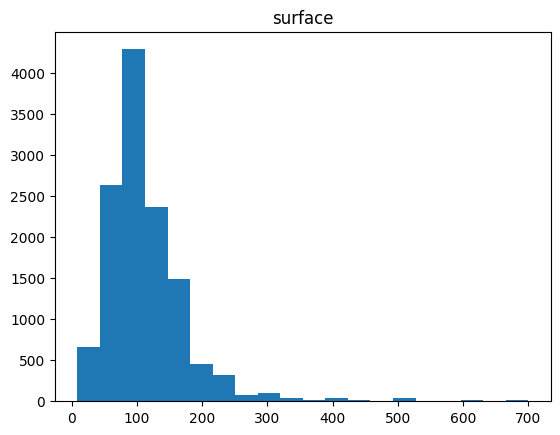

c:\Users\arocheteau\OneDrive - ASI\Documents\1_perso\projet\datalake\notebook\pySpark\lib\show.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%1.2f%%' %i for i in vals])


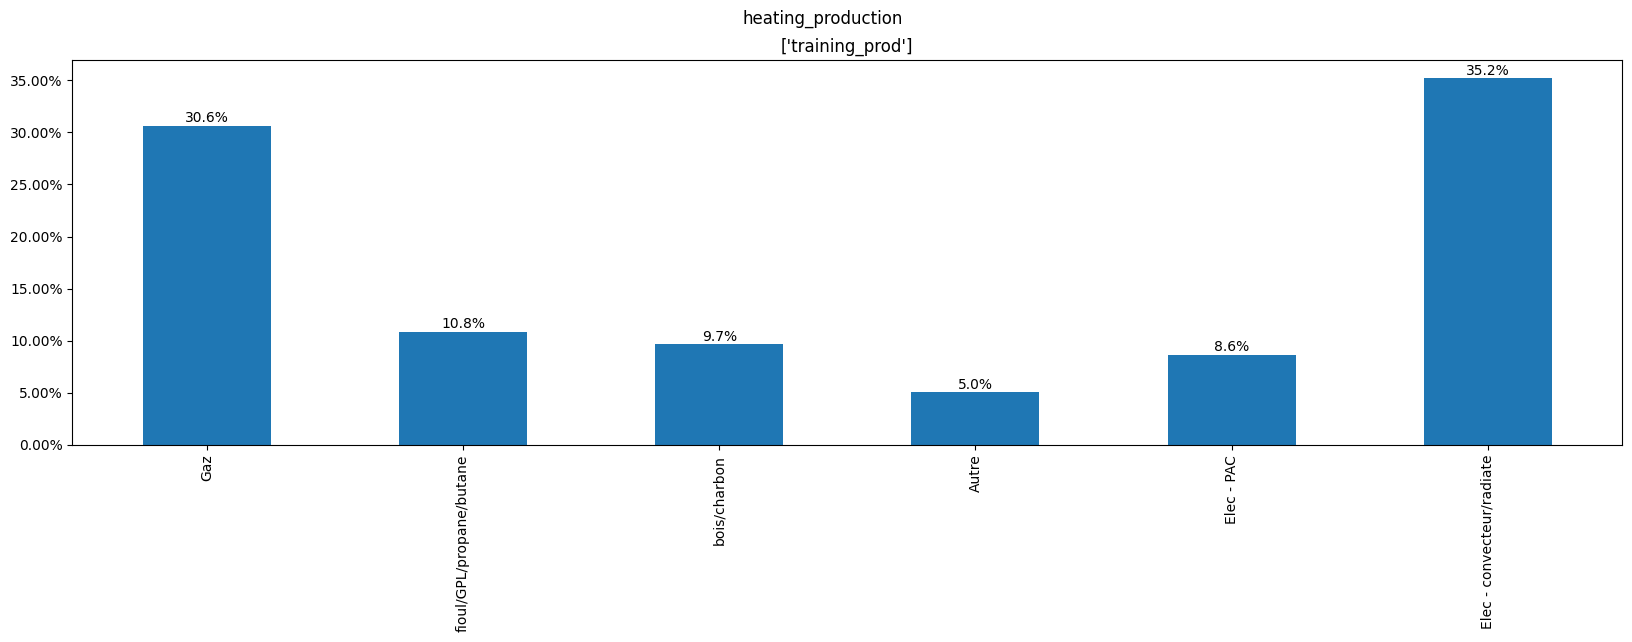

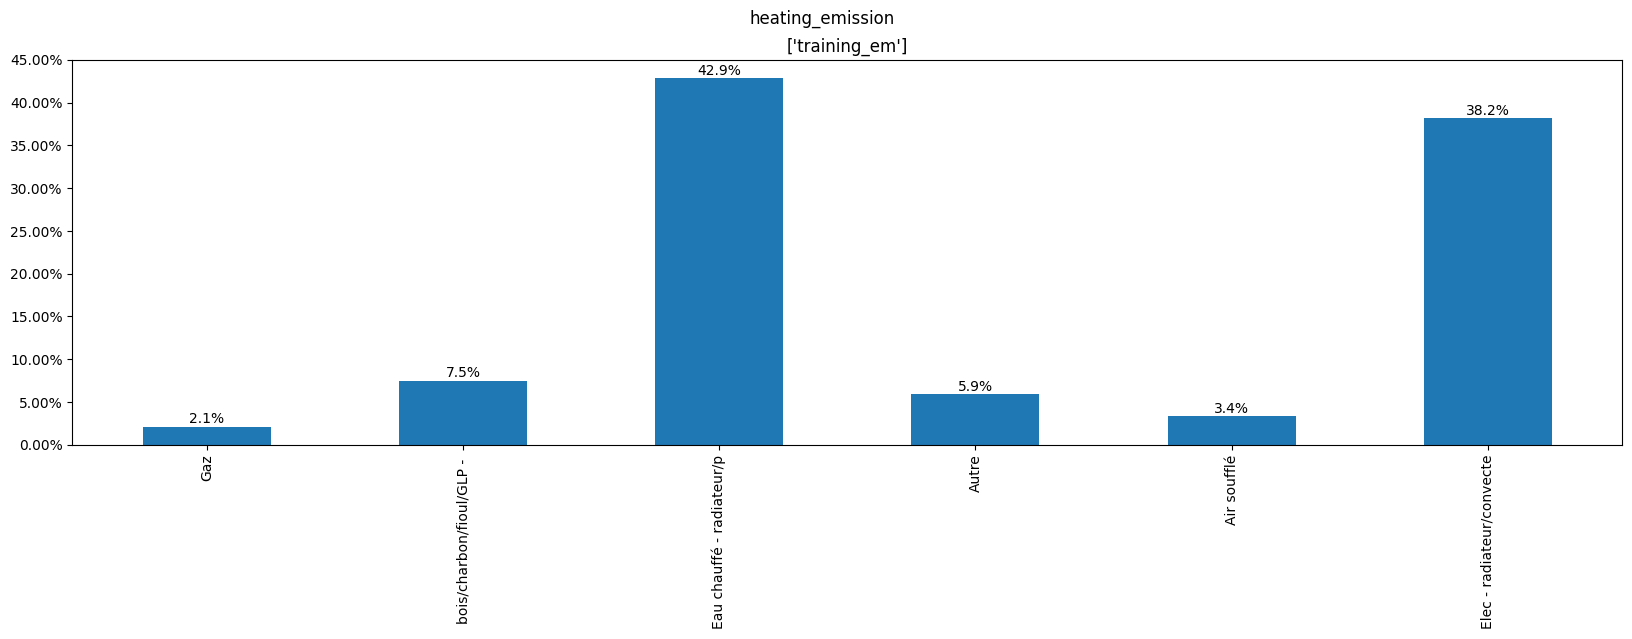

In [8]:
histo_continuous(training_surf, 'surface')
compare_repartition([training_prod], dictionary, 'heating_production')
compare_repartition([training_em], dictionary, 'heating_emission')

# ML

In [9]:
#librairies
import numpy as np
import matplotlib.pyplot as plt

#usefull
from copy import deepcopy

#linear
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression

#random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

# XGboost
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

# make cut Surf

In [10]:
col_X_hot = [[]]
col_y = ['surface']
col_X_not_hot = [[col[0] for col in training_surf.dtypes if col[0] not in col_X_hot + col_y ]]

hyperparams_models = [
    {
        'n_estimators' : [100],
        # 'criterion' : ["squared_error", "absolute_error", "friedman_mse"],
        'max_depth' : [10],
        'class_weight' : ['balanced'],
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
        # 'max_features' : ["sqrt", "log2", "auto"]
    }
]
models = {
    'RandomForestClassifier' : RandomForestClassifier
}
cut_params = {
    'first_value' : [30,40,50,60,70],
    'steps' : [25,30,35,40],
    'nb_steps' : [1,2,3]
}

current = [0 for _ in range(len(cut_params))]
max_hyper = [len(cut_param) - 1 for cut_param in cut_params.values()]
current_params = choose_params(current, cut_params)
all_poss = nb_possibility(max_hyper)
print(all_poss)

cuts = make_cut(**current_params)
categorical_surf, coef = to_categorical(training_surf, 'surface', cuts)
# register score
best_models = all_in_one(categorical_surf, dictionary, col_X_hot, col_X_not_hot, col_y, False, True, hyperparams_models, models, degree_poly=1, random_state=42, test_size=0.4, show=False)
max_score = deepcopy(best_models['RandomForestClassifier'][1])
best_split = deepcopy(current_params)
scores = {}
coefs = {}
score_corrected = coef * best_models['RandomForestClassifier'][1]
print(score_corrected)
coefs[tuple([param for param in current_params.values()])] = deepcopy(coef)
scores[tuple([param for param in current_params.values()])] = deepcopy(score_corrected)

i = 0
nb_print = (all_poss//4) + 1
while not all(np.equal(current, max_hyper)):
    # choose params
    current = iterate_params(current, max_hyper)
    current_params = choose_params(current, cut_params)
    if i % nb_print == 0:
        print(i, current)
    i += 1
    cuts = make_cut(**current_params)
    categorical_surf, coef = to_categorical(training_surf, 'surface', cuts)
    best_models = all_in_one(categorical_surf, dictionary, col_X_hot, col_X_not_hot, col_y, False, True, hyperparams_models, models, degree_poly=1, random_state=42, test_size=0.4, show=False)
    score_corrected = coef * best_models['RandomForestClassifier'][1]
    print(score_corrected)
    scores[tuple([param for param in current_params.values()])] = deepcopy(score_corrected)
    coefs[tuple([param for param in current_params.values()])] = deepcopy(coef)
    if score_corrected > max_score:
        max_score = deepcopy(score_corrected)
        best_split = deepcopy(current_params)

60
1
0.8851472343812177 {'n_estimators': 100, 'max_depth': 10, 'class_weight': 'balanced'}


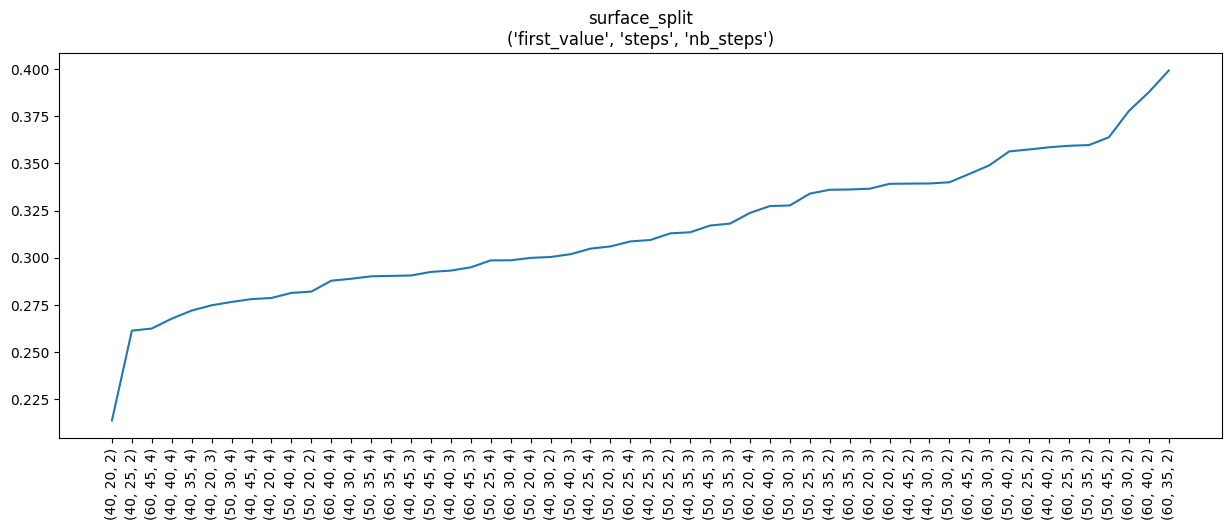

In [ ]:
f, ax_hyper = plt.subplots(1, 1, figsize=(15,5), sharey= True)
# show_hyperparam_opti(coefs, cut_params, ax_hyper, 'surface_split')
show_hyperparam_opti(scores, cut_params, ax_hyper, 'surface_split')
plt.show()

In [ ]:
# make the best split
sorted_score = sorted(scores.items(), key=lambda x:x[1])
best_cut = sorted_score[-1][0]
cuts = make_cut(*best_cut)
training_surf, coef = to_categorical(training_surf, 'surface', cuts)


## surface

4
0 {'max_iter': 300, 'C': 1, 'class_weight': 'balanced'}
2 {'max_iter': 300, 'C': 100, 'class_weight': 'balanced'}
0.46473338639076806 {'max_iter': 300, 'C': 100, 'class_weight': 'balanced'}
6
0 {'n_estimators': 200, 'max_depth': 10, 'class_weight': 'balanced'}
2 {'n_estimators': 200, 'max_depth': 35, 'class_weight': 'balanced'}
4 {'n_estimators': 200, 'max_depth': None, 'class_weight': 'balanced'}
0.5055710306406686 {'n_estimators': 200, 'max_depth': 35, 'class_weight': 'balanced'}
27
0 {'learning_rate': 0.1, 'n_estimators': 50, 'max_depth': 3}
7 {'learning_rate': 0.2, 'n_estimators': 200, 'max_depth': 3}
14 {'learning_rate': 0.05, 'n_estimators': 200, 'max_depth': 5}


KeyboardInterrupt: 

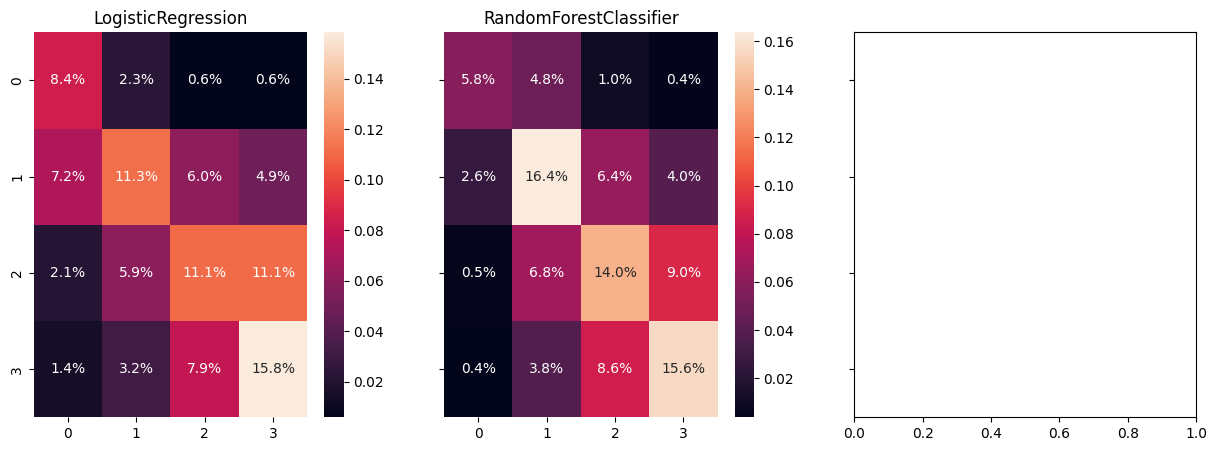

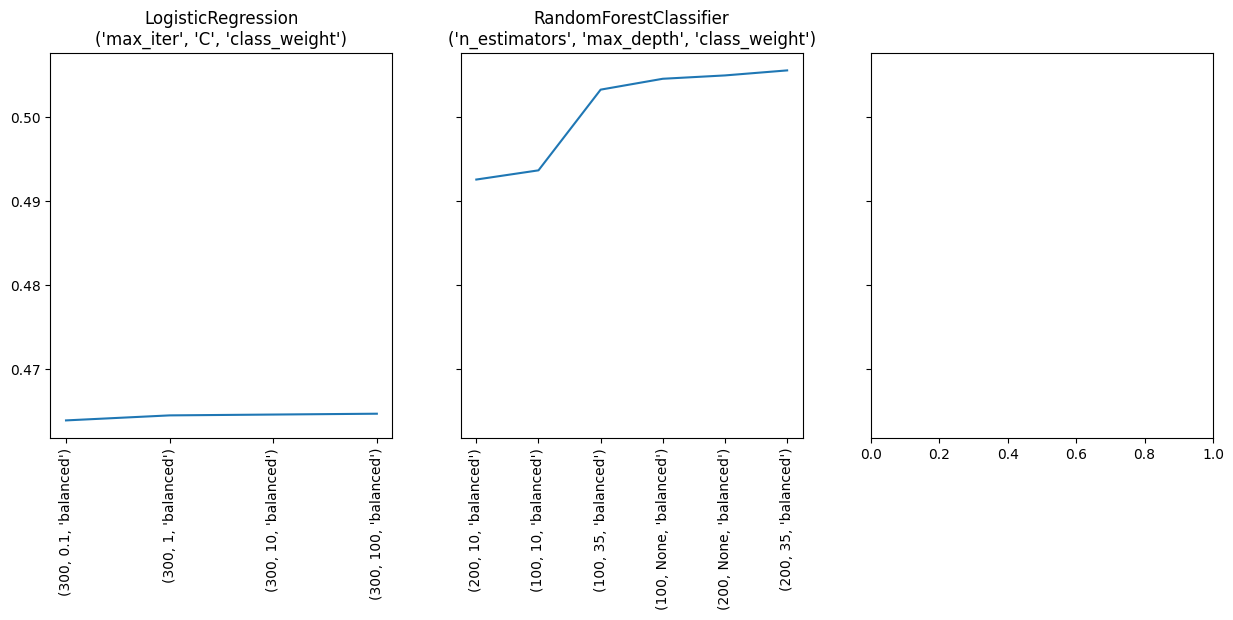

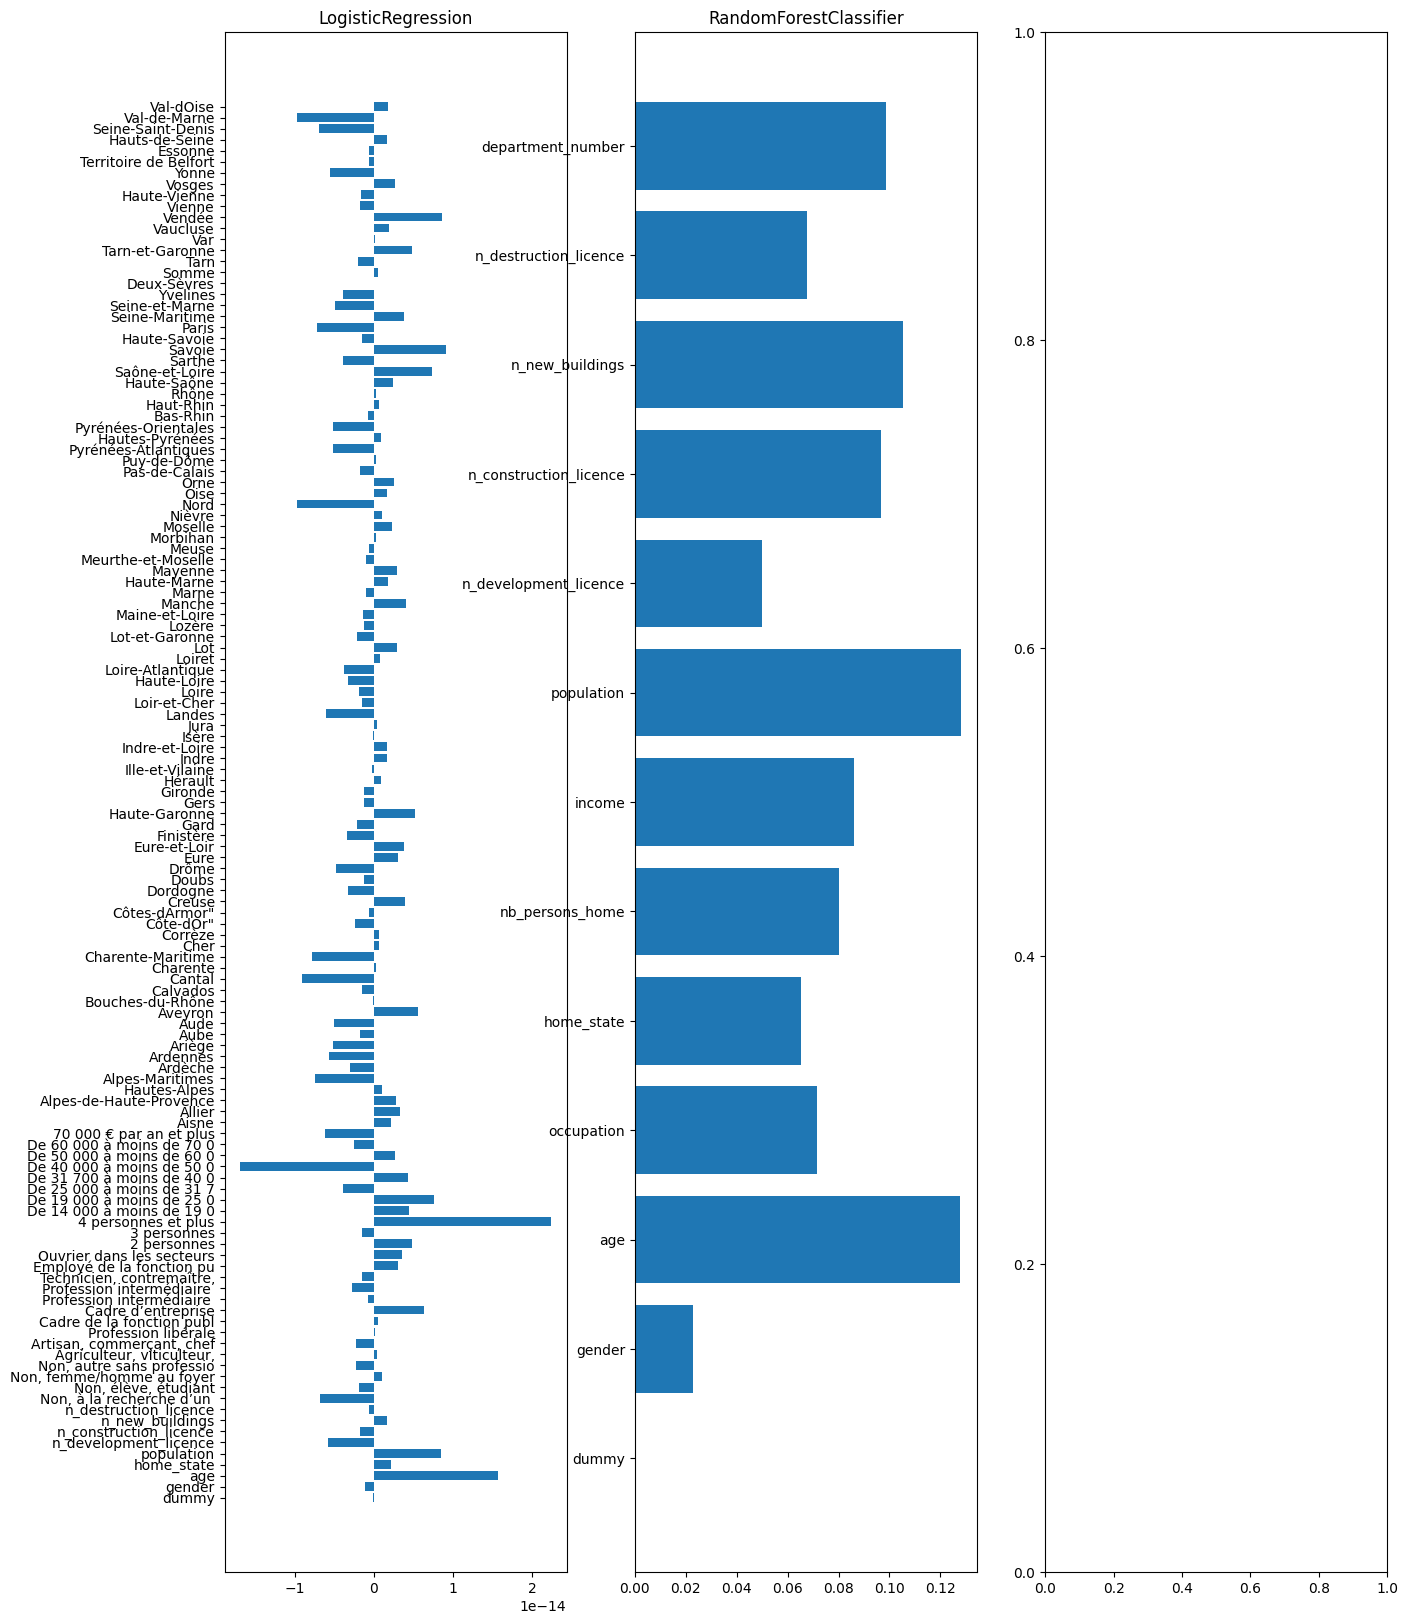

In [ ]:
col_X_hot = [['occupation', 'nb_persons_home', 'income', 'department_number'], [], []]
col_y = ['surface']
col_X_not_hot = [
    [col[0] for col in training_surf.dtypes if col[0] not in col_X_hot[0] + col_y ],
    [col[0] for col in training_surf.dtypes if col[0] not in col_X_hot[1] + col_y],
    [col[0] for col in training_surf.dtypes if col[0] not in col_X_hot[2] + col_y]
]

hyperparams_models = [
    {
        'max_iter' : [300],
        'C' : [0.1, 1, 10, 100],
        'class_weight' : ['balanced'],
    },
    {
        'n_estimators' : [100, 200],
        # 'criterion' : ["squared_error", "absolute_error", "friedman_mse"],
        'max_depth' : [10, 35, None],
        'class_weight' : ['balanced'],
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
        # 'max_features' : ["sqrt", "log2", "auto"]
    },
    {
        'learning_rate' : [0.05, 0.1, 0.2],
        'n_estimators' : [50, 100, 200],
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        'max_depth' : [3, 5, 10],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    }
]
models = {
    'LogisticRegression' : LogisticRegression,
    'RandomForestClassifier' : RandomForestClassifier,
    'GradientBoostingClassifier' : GradientBoostingClassifier
}
best_models = all_in_one(training_surf, dictionary, col_X_hot, col_X_not_hot, col_y, False, True, hyperparams_models, models, degree_poly=1, random_state=42, test_size=0.4)


## heating_production 

Py4JJavaError: An error occurred while calling o19331.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 7438.0 failed 1 times, most recent failure: Lost task 0.0 in stage 7438.0 (TID 12429) (PORT-PF3TSJ9G.asi.fr executor driver): org.apache.spark.SparkFileNotFoundException: File file:/c:/Users/arocheteau/OneDrive - ASI/Documents/1_perso/projet/datalake/training/pred_tremi_v2.csv does not exist
It is possible the underlying files have been updated. You can explicitly invalidate the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by recreating the Dataset/DataFrame involved.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.readCurrentFileNotFoundError(QueryExecutionErrors.scala:794)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:231)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:290)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:125)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:888)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:888)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:971)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2284)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2303)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2328)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1019)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1018)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:448)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3997)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4167)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:526)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4165)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:118)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:195)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:103)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:827)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:65)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4165)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3994)
	at sun.reflect.GeneratedMethodAccessor111.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.SparkFileNotFoundException: File file:/c:/Users/arocheteau/OneDrive - ASI/Documents/1_perso/projet/datalake/training/pred_tremi_v2.csv does not exist
It is possible the underlying files have been updated. You can explicitly invalidate the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by recreating the Dataset/DataFrame involved.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.readCurrentFileNotFoundError(QueryExecutionErrors.scala:794)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:231)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:290)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:125)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:888)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:888)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


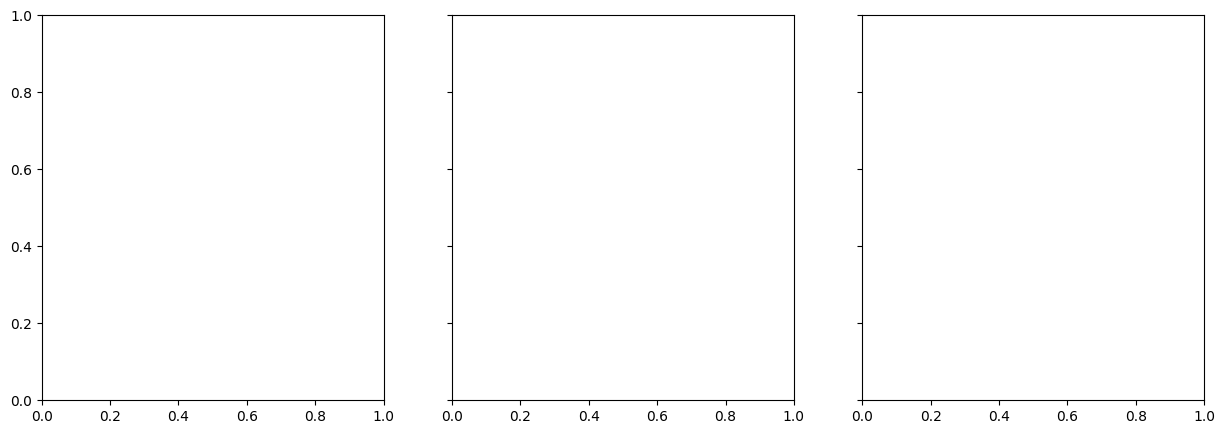

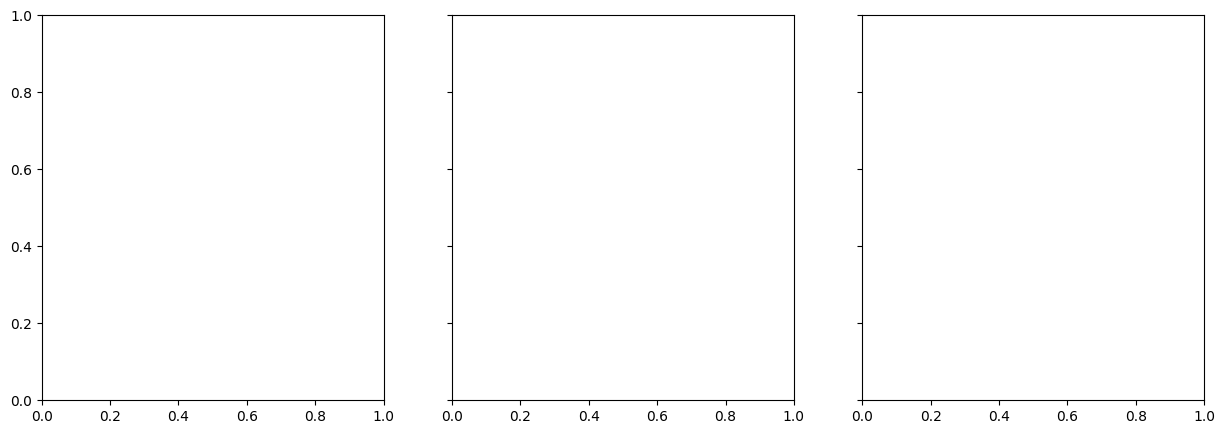

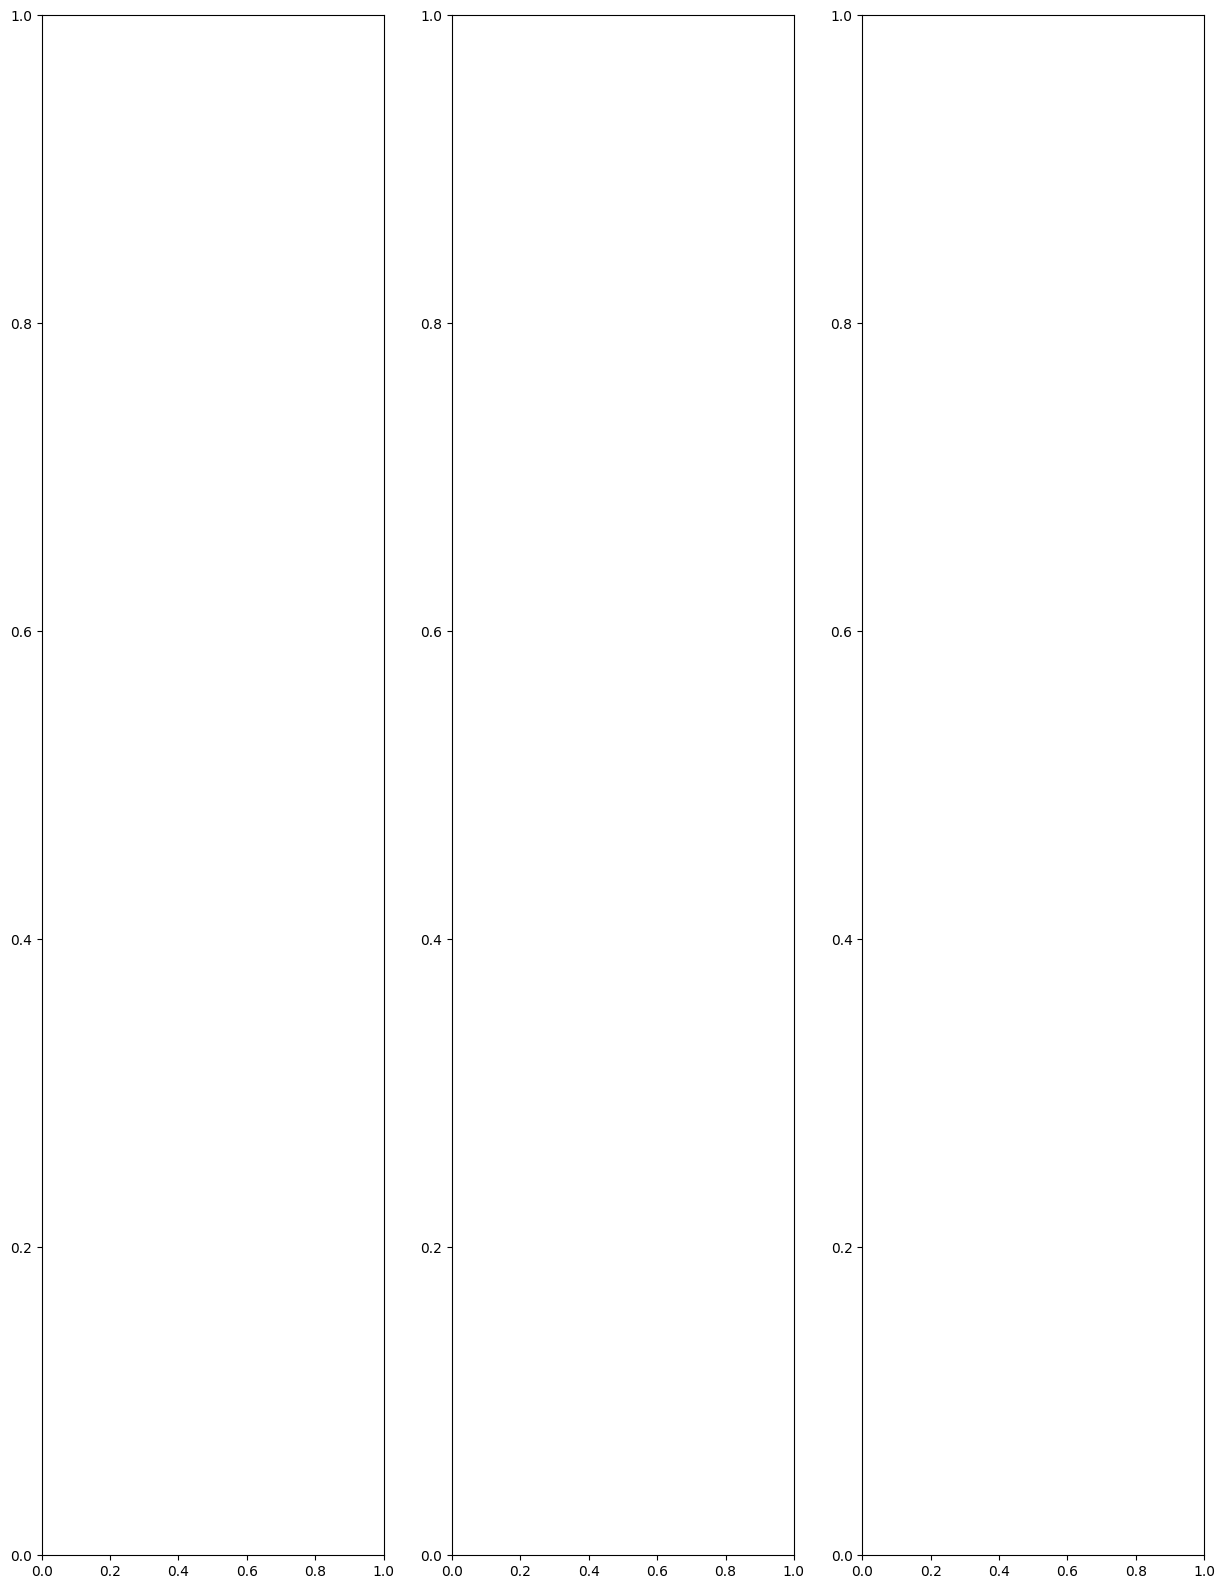

In [ ]:
col_X_hot = [['occupation', 'nb_persons_home', 'income', 'department_number'], [], []]
col_y = ['heating_production']
col_X_not_hot = [
    [col[0] for col in training_prod.dtypes if col[0] not in col_X_hot[0] + col_y ],
    [col[0] for col in training_prod.dtypes if col[0] not in col_X_hot[1] + col_y],
    [col[0] for col in training_prod.dtypes if col[0] not in col_X_hot[2] + col_y]
]

hyperparams_models = [
    {
        'max_iter' : [300],
        'C' : [0.1, 1, 10, 100],
        'class_weight' : ['balanced'],
    },
    {
        'n_estimators' : [100, 200],
        # 'criterion' : ["squared_error", "absolute_error", "friedman_mse"],
        'max_depth' : [10, 35, None],
        'class_weight' : ['balanced'],
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
        # 'max_features' : ["sqrt", "log2", "auto"]
    },
    {
        'learning_rate' : [0.05, 0.1, 0.2],
        'n_estimators' : [50, 100, 200],
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        'max_depth' : [3, 5, 10],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    }
]
models = {
    'LogisticRegression' : LogisticRegression,
    'RandomForestClassifier' : RandomForestClassifier,
    'GradientBoostingClassifier' : GradientBoostingClassifier
}
best_models = all_in_one(training_prod, dictionary, col_X_hot, col_X_not_hot, col_y, False, True, hyperparams_models, models, degree_poly=1, random_state=42, test_size=0.4)


## heating_emission

In [ ]:
col_X_hot = [['occupation', 'nb_persons_home', 'income', 'department_number'], [], []]
col_y = ['heating_emission']
col_X_not_hot = [
    [col[0] for col in training_em.dtypes if col[0] not in col_X_hot[0] + col_y ],
    [col[0] for col in training_em.dtypes if col[0] not in col_X_hot[1] + col_y],
    [col[0] for col in training_em.dtypes if col[0] not in col_X_hot[2] + col_y]
]

hyperparams_models = [
    {
        'max_iter' : [300],
        'C' : [0.1, 1, 10, 100],
        'class_weight' : ['balanced'],
    },
    {
        'n_estimators' : [100, 200],
        # 'criterion' : ["squared_error", "absolute_error", "friedman_mse"],
        'max_depth' : [10, 35, None],
        'class_weight' : ['balanced'],
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
        # 'max_features' : ["sqrt", "log2", "auto"]
    },
    {
        'learning_rate' : [0.05, 0.1, 0.2],
        'n_estimators' : [50, 100, 200],
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        'max_depth' : [3, 5, 10],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    }
]
models = {
    'LogisticRegression' : LogisticRegression,
    'RandomForestClassifier' : RandomForestClassifier,
    'GradientBoostingClassifier' : GradientBoostingClassifier
}
best_models = all_in_one(training_em, dictionary, col_X_hot, col_X_not_hot, col_y, False, True, hyperparams_models, models, degree_poly=1, random_state=42, test_size=0.4)
